In [1]:
!pip install category_encoders

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split

from category_encoders import MEstimateEncoder

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# import dataset

df = pd.read_csv('HousePrice.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   int64  
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

In [5]:
df.isnull().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
street           0
city             0
statezip         0
country          0
dtype: int64

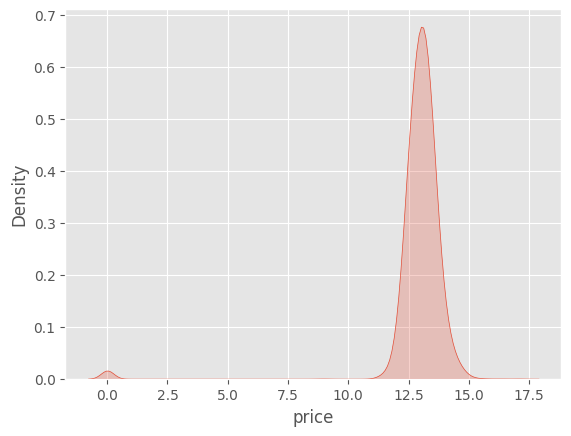

In [6]:
#checking the distribution of the target column
sns.kdeplot(df['price'].apply(np.log1p), fill=True)
plt.show()

In [7]:
X = df.drop(columns=['price'])
y = df[['price']]

In [8]:
# Function to create Z-Score
def make_mi_score(x,y):
    x = x.copy()
    for colname in x.select_dtypes(['object','category']):
        x[colname], _ = x[colname].factorize()

    discrete_features = [pd.api.types.is_integer_dtype(t) for t in x.dtypes]
    mi_score = mutual_info_regression(x, y, discrete_features=discrete_features, random_state=42)
    mi_score = pd.Series(mi_score, name='Mutual Information Score', index=x.columns)
    mi_score = mi_score.sort_values(ascending=False)
    return mi_score

mi_score = make_mi_score(X, y)
mi_score

  File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


street           1.188303
statezip         0.456874
city             0.313397
sqft_living      0.299026
sqft_above       0.200801
bathrooms        0.189481
sqft_lot         0.147281
bedrooms         0.077861
yr_built         0.076079
floors           0.067790
view             0.051736
sqft_basement    0.045861
yr_renovated     0.016520
waterfront       0.006245
date             0.004135
condition        0.003594
country          0.000000
Name: Mutual Information Score, dtype: float64

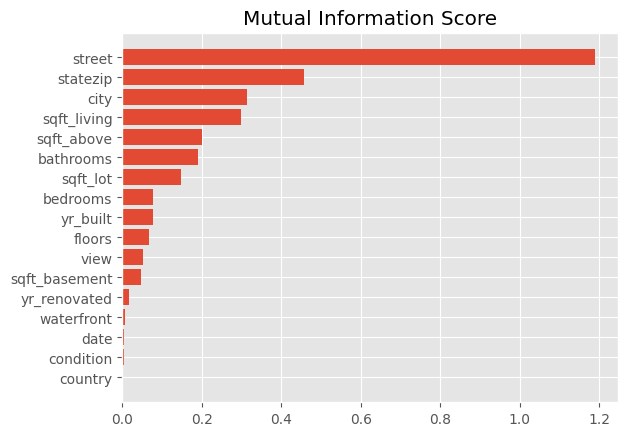

In [9]:
def plot_mi_score(score):
    score = score.sort_values(ascending = True)
    width = np.arange(len(score))
    ticks = list(score.index)
    plt.barh(width,score)
    plt.yticks(width,ticks)
    plt.title('Mutual Information Score')

plot_mi_score(mi_score)

In [10]:
# Refining the dataset based on mutual information score

df = df[['street','statezip','city','sqft_living','sqft_above','bathrooms','yr_built','sqft_lot','bedrooms']]

In [11]:
df

,street,statezip,city,sqft_living,sqft_above,bathrooms,yr_built,sqft_lot,bedrooms
0,18810 Densmore Ave N,WA 98133,Shoreline,1340,1340,1.50,1955,7912,3
1,709 W Blaine St,WA 98119,Seattle,3650,3370,2.50,1921,9050,5
2,26206-26214 143rd Ave SE,WA 98042,Kent,1930,1930,2.00,1966,11947,3
3,857 170th Pl NE,WA 98008,Bellevue,2000,1000,2.25,1963,8030,3
4,9105 170th Ave NE,WA 98052,Redmond,1940,1140,2.50,1976,10500,4
...,...,...,...,...,...,...,...,...,...
4595,501 N 143rd St,WA 98133,Seattle,1510,1510,1.75,1954,6360,3
4596,14855 SE 10th Pl,WA 98007,Bellevue,1460,1460,2.50,1983,7573,3
4597,759 Ilwaco Pl NE,WA 98059,Renton,3010,3010,2.50,2009,7014,3
4598,5148 S Creston St,WA 98178,Seattle,2090,1070,2.00,1974,6630,4


In [12]:
z = np.abs(stats.zscore(df[['sqft_living','sqft_above','bathrooms','yr_built','sqft_lot','bedrooms']]))
print(z)

      sqft_living  sqft_above  bathrooms  yr_built  sqft_lot  bedrooms
0        0.829971    0.565224   0.843204  0.531014  0.193434  0.441122
1        1.568528    1.789559   0.432802  1.674693  0.161718  1.759705
2        0.217367    0.119171   0.205201  0.161000  0.080978  0.441122
3        0.144686    0.959621   0.113800  0.261913  0.190145  0.441122
4        0.206984    0.797222   0.432802  0.175376  0.121306  0.659291
...           ...         ...        ...       ...       ...       ...
4595     0.653458    0.368025   0.524202  0.564651  0.236689  0.441122
4596     0.705374    0.426025   0.432802  0.410840  0.202882  0.441122
4597     0.904009    1.371962   0.432802  1.285418  0.218462  0.441122
4598     0.051238    0.878421   0.205201  0.108101  0.229164  0.659291
4599     0.674224    0.391225   0.432802  0.646303  0.188139  0.441122

[4600 rows x 6 columns]


In [13]:
threshold = 3
print(np.where(z > 3))

(array([  56,  107,  122,  122,  122,  122,  122,  217,  227,  233,  240,
        241,  252,  252,  252,  254,  272,  291,  291,  375,  418,  418,
        452,  461,  462,  462,  462,  462,  471,  479,  484,  495,  548,
        575,  581,  581,  634,  634,  634,  675,  679,  743,  747,  779,
        798,  839,  847,  878,  879,  999, 1017, 1031, 1078, 1089, 1103,
       1128, 1130, 1132, 1132, 1182, 1182, 1209, 1209, 1209, 1261, 1265,
       1272, 1275, 1275, 1301, 1302, 1302, 1360, 1390, 1406, 1408, 1411,
       1417, 1417, 1424, 1455, 1479, 1500, 1539, 1567, 1567, 1571, 1602,
       1637, 1644, 1722, 1762, 1786, 1944, 1952, 1952, 1962, 1962, 2005,
       2005, 2152, 2155, 2157, 2199, 2226, 2279, 2286, 2286, 2300, 2316,
       2328, 2328, 2328, 2365, 2401, 2480, 2551, 2588, 2654, 2654, 2654,
       2717, 2725, 2731, 2731, 2731, 2731, 2761, 2761, 2846, 2846, 2855,
       2872, 2889, 2917, 2967, 2967, 2967, 2968, 2980, 2980, 3004, 3004,
       3004, 3004, 3046, 3056, 3099, 3117, 3122, 3

In [14]:
df = df[(z < 3).all(axis=1)]

In [15]:
df.shape

(4435, 9)

In [16]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [17]:
encoder = MEstimateEncoder(cols=['street','statezip','city'], m=0.5)

X = encoder.fit_transform(X, y)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

In [19]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [20]:
model.score(X_train, y_train)

0.9900217790880281

In [21]:
model.score(X_test, y_test)

0.9880309877338705